# kNN from Scratch
- Implement kNN from scratch
- Use MNIST handwriting dataset for evaluation
- Use the kNN model in sklearn for comparison

In [87]:
import struct
import os
import numpy as np
import matplotlib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.random import sample_without_replacement
import random
import math
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

## Load the Dataset
- Link: http://yann.lecun.com/exdb/mnist/
- The data reader is based on: https://colab.research.google.com/github/chokkan/deeplearningclass/blob/master/mnist.ipynb#scrollTo=TStlGwaUaZKC

In [244]:
def read_mnist_dataset(dir_minst):
    training_img_file = os.path.join(dir_minst, 'train-images-idx3-ubyte')
    training_label_file = os.path.join(dir_minst, 'train-labels-idx1-ubyte')
    
    test_img_file = os.path.join(dir_minst, 't10k-images-idx3-ubyte')
    test_label_file = os.path.join(dir_minst, 't10k-labels-idx1-ubyte')
    
    # read the training set
    training_label = None
    with open(training_label_file, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        training_label = np.fromfile(f, dtype=np.int8)
    
    training_img = None
    with open(training_img_file, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        training_img = np.fromfile(f, dtype=np.uint8).reshape(len(training_label), rows, cols)
        
    # read the testing set
    test_label = None
    with open(test_label_file, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        test_label = np.fromfile(f, dtype=np.int8)
    
    test_img = None
    with open(test_img_file, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        test_img = np.fromfile(f, dtype=np.uint8).reshape(len(test_label), rows, cols)
        
    return training_img.astype(np.float64), training_label, test_img.astype(np.float64), test_label

data_dir = 'dataset/MNIST'
training_img, training_label, test_img, test_label = read_mnist_dataset(data_dir)
training_img_vectors = np.reshape(training_img, (training_img.shape[0], -1))
test_img_vectors = np.reshape(test_img, (test_img.shape[0], -1))

print('training image shape: ', training_img.shape)
print('training image vectors shape: ', training_img_vectors.shape)
print('training label shape: ', training_label.shape)
print('test image shape: ', test_img.shape)
print('test image vectors shape: ', test_img_vectors.shape)
print('test label shape: ', test_label.shape)

# the dataset is too big, so we use a subset of it
print('\nAfter sampling: ')
traning_subset_idx = sample_without_replacement(n_population=training_img_vectors.shape[0], n_samples=10000)
training_img_vectors = training_img_vectors[traning_subset_idx]
training_label = training_label[traning_subset_idx]
training_img = training_img[traning_subset_idx]

test_subset_idx = sample_without_replacement(n_population=test_img_vectors.shape[0], n_samples=1000)
test_img_vectors = test_img_vectors[test_subset_idx]
test_label = test_label[test_subset_idx]
test_img = test_img[test_subset_idx]

print('training image shape: ', training_img.shape)
print('training image vectors shape: ', training_img_vectors.shape)
print('training label shape: ', training_label.shape)
print('test image shape: ', test_img.shape)
print('test image vectors shape: ', test_img_vectors.shape)
print('test label shape: ', test_label.shape)

training image shape:  (60000, 28, 28)
training image vectors shape:  (60000, 784)
training label shape:  (60000,)
test image shape:  (10000, 28, 28)
test image vectors shape:  (10000, 784)
test label shape:  (10000,)

After sampling: 
training image shape:  (10000, 28, 28)
training image vectors shape:  (10000, 784)
training label shape:  (10000,)
test image shape:  (1000, 28, 28)
test image vectors shape:  (1000, 784)
test label shape:  (1000,)


### Visualize the Data (Training)

Label:  2


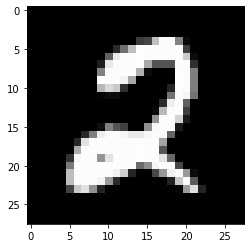

In [185]:
print('Label: ', training_label[0])
plt.imshow(training_img_vectors[0].reshape(28,28),cmap='gray')
plt.show()

### Visualize the Data (Test)

Label:  7


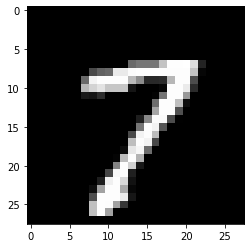

In [186]:
print('Label: ', test_label[9])
plt.imshow(test_img_vectors[9].reshape(28,28),cmap='gray')
plt.show()

## kNN Model

- The implementation has a complexity of $O(nd+kn)$ (since d<<n and k<<n, we have $O(nd+kn)=O(n)$), where d is the data dimension and n is the number of training data

In [245]:
def euclidean_dist(data_0, data_1): 
    return np.linalg.norm(data_0 - data_1, ord=2)


class kNN_model:
    def __init__(self, n_neighbors, dist=euclidean_dist):
        self.dist_func = dist
        self.k = n_neighbors
        self.X = None
        self.y = None
        
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, data_x):
        prediction = []
        for data_point in data_x:
            prediction.append(self.predict_each(data_point))
        return prediction
    
    def predict_each(self, data_x):
        neighbor_idx, _ = self.k_neighbors(data_x)

        # use the selected neighbors to get the prediction
        votes = list()
        for idx in neighbor_idx:
            votes.append(self.y[idx])
        vote_counter = Counter(votes)
        # return the most frequent
        return vote_counter.most_common()[0][0]
    
    def k_neighbors(self, data_x):
        n_data = self.X.shape[0]
        is_selected = np.zeros(shape=(n_data,), dtype=np.int8)
        neighbor_idx = list()
        
        # calculate the distance
        distance = np.zeros(shape=(n_data,))
        for x_i, x in enumerate(self.X):
            distance[x_i] = self.dist_func(data_x, x)

        for _ in range(0, self.k):
            current_min = None
            current_min_index = None
            
            for x_i, x in enumerate(self.X):
                if is_selected[x_i] == 1:
                    continue
                
                dist_to_neighbor = distance[x_i]
                if current_min is None or current_min > dist_to_neighbor:
                    current_min = dist_to_neighbor
                    current_min_index = x_i
                
            # select the current minimum
            is_selected[current_min_index] = 1
            neighbor_idx.append(current_min_index)
        return neighbor_idx, distance[neighbor_idx]

### Evaluation

In [246]:
def run_evaluation(model_to_use, training_X, training_y, test_X, test_y):
    k_list = [1, 3, 5, 10, 20, 30, 40, 50, 60]
    accuracy = []
    n_test = float(test_y.shape[0])
    
    for k in k_list:
        model = model_to_use(n_neighbors=k)
        model.fit(training_X, training_y)
        
        n_correct = 0
        for test_idx in range(0, int(n_test)):
            
            prediction = model.predict([test_X[test_idx]])[0]
            true_prediction = test_y[test_idx]
            if prediction == true_prediction:
                n_correct += 1
            
            log_str = '\rk: %d, test data: %d/%d, prediction: %d, true prediction: %d, current accuray: %f' % (k, test_idx, n_test-1, prediction, true_prediction, float(n_correct/(test_idx+1)))
            sys.stdout.write(log_str)
            sys.stdout.flush()
            
        accuracy_k = n_correct/n_test
        print('\nk: ', k, ', accuracy: ', accuracy_k)
        accuracy.append(accuracy_k)
        
        return accuracy

accuracy_knn = run_evaluation(kNN_model, training_img_vectors, training_label, test_img_vectors, test_label)

k: 1, test data: 999/999, prediction: 5, true prediction: 8, current accuray: 0.944000
k:  1 , accuracy:  0.944
k: 3, test data: 999/999, prediction: 5, true prediction: 8, current accuray: 0.945000
k:  3 , accuracy:  0.945
k: 5, test data: 768/999, prediction: 7, true prediction: 7, current accuray: 0.946684

KeyboardInterrupt: 

## Compare to the kNN in skkearn

In [243]:
accuracy_knn_sklearn = run_evaluation(KNeighborsClassifier, training_img_vectors, training_label, test_img_vectors, test_label)

sk:  2942.7641767562686
float64
float64
a: 2942.7641767562686
b: 2942.7641767562686
c: 2942.7641767562686
(784,)
2
(784,)
0
